In [1]:
!pip install qiskit==0.39.4
!pip install pylatexenc
!pip install matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.7/929.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 7.9 MB/s eta 0:00:00
  Created wheel for qiskit: filename=qiskit-0.39.4-py3-none-any.whl size=12249 sha256=708385f2990fb7b11b2aa975c18cf0f9cd0c2d745a224d8768c4b302a9584e71
  Stored in direc

In [2]:
import numpy as np
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle

In [3]:
cnf_formula = "(~x1 | ~x2) & (x1 | x2) & (~x3 | ~x4) & (x3 | x4) & (~x1 | ~x5) & (x1 | x5) & (~x1 | ~x4) & (x1 | x4) "
oracle = PhaseOracle(cnf_formula)
oracle.draw()

q_0: ─■──o─
      │  │ 
q_1: ─o──■─
      │  │ 
q_2: ─■──o─
      │  │ 
q_3: ─o──■─
      │  │ 
q_4: ─o──■─

In [4]:
import re
class Verifier():
    """Create an object that can be used to check whether
    an assignment satisfies a given CNF formula.
        Args:
            cnf_formula (str): CNF formula string
    """
    def __init__(self, cnf_formula):
        self.cnf_formula = cnf_formula
        # 從公式中擷取變數名稱 (例如 x11, x12, x21 ...)
        self.variables = re.findall(r'x\d+', cnf_formula)
        # 移除重複變數並排序，以建立固定的變數順序
        self.unique_vars = sorted(set(self.variables))
        # 建立變數名稱對索引的映射（索引從0開始）
        self.var_to_idx = {var: i for i, var in enumerate(self.unique_vars)}

    def is_correct(self, guess):
        """Verifies a SAT solution against the CNF formula.
            Args:
                guess (str): Assignment to be verified (e.g. '00110')
                             Must be a string of 1s (True) and 0s (False).
            Returns:
                bool: True if `guess` satisfies the formula. False otherwise.
        """
        # Convert guess characters to bools (True/False)
        # 下例不反轉順序，如果您的應用需要反轉，請依需求更改。
        guess_bool = [bool(int(x)) for x in guess]

        # 使用正則拆解CNF: 用'&'拆 clause
        clauses = self.cnf_formula.split('&')
        for clause in clauses:
            # 移除外圍空白與括號
            clause = clause.strip()
            clause = clause.strip('() ')

            # 拆分子句成 literals
            literals = clause.split('|')

            clause_val = False
            for lit in literals:
                lit = lit.strip()
                # 判斷是否有否定符號 '~'
                neg = '~' in lit
                # 移除 '~' 以取得變數名稱
                var_name = lit.replace('~', '').strip()

                # 取得對應變數的值
                idx = self.var_to_idx[var_name]
                val = guess_bool[idx]

                # 若為否定取反
                if neg:
                    val = not val

                # 若此literal為True，整個子句就成立
                clause_val = clause_val or val

                # 如果已經為True，就不用再繼續看後面literals了
                if clause_val:
                    break

            # 若子句為False，整個CNF就不成立
            if not clause_val:
                return False

        # 所有子句都True
        return True

In [5]:
v = Verifier(cnf_formula)
v.is_correct('00001')

False

In [8]:
# Configure backend
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)

# Create a new problem from the phase oracle and the
# verification function
problem = AmplificationProblem(oracle=oracle, is_good_state=v.is_correct)

# Use Grover's algorithm to solve the problem
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)
result.top_measurement

'00110'

In [7]:
# 獲取測量次數的分佈
measurement_counts = result.circuit_results

# 打印完整的測量分佈
print("Measurement Counts:")
# Iterate through the list of dictionaries
for measurement in measurement_counts:
    # Get the state and count from each dictionary
    for state, count in measurement.items():
        print(f"State: {state}, Count: {count}")

# 總測量次數
# Sum the counts from all dictionaries in the list
total_counts = sum(count for measurement in measurement_counts for count in measurement.values())
print(f"Total Measurements: {total_counts}")

Measurement Counts:
State: 01001, Count: 15
State: 10011, Count: 17
State: 00100, Count: 14
State: 10000, Count: 17
State: 11111, Count: 17
State: 11011, Count: 16
State: 00111, Count: 24
State: 00011, Count: 21
State: 01011, Count: 18
State: 01111, Count: 15
State: 11100, Count: 21
State: 10010, Count: 18
State: 10101, Count: 15
State: 10001, Count: 21
State: 00101, Count: 252
State: 11010, Count: 240
State: 01110, Count: 19
State: 01010, Count: 16
State: 10110, Count: 12
State: 00001, Count: 13
State: 00110, Count: 21
State: 11001, Count: 20
State: 00000, Count: 25
State: 00010, Count: 13
State: 01101, Count: 19
State: 01000, Count: 17
State: 01100, Count: 21
State: 11110, Count: 15
State: 10111, Count: 20
State: 10100, Count: 12
State: 11101, Count: 22
State: 11000, Count: 18
State: 01010, Count: 11
State: 01001, Count: 16
State: 00010, Count: 21
State: 11101, Count: 26
State: 10011, Count: 20
State: 01110, Count: 16
State: 00101, Count: 243
State: 11010, Count: 240
State: 10001, Co

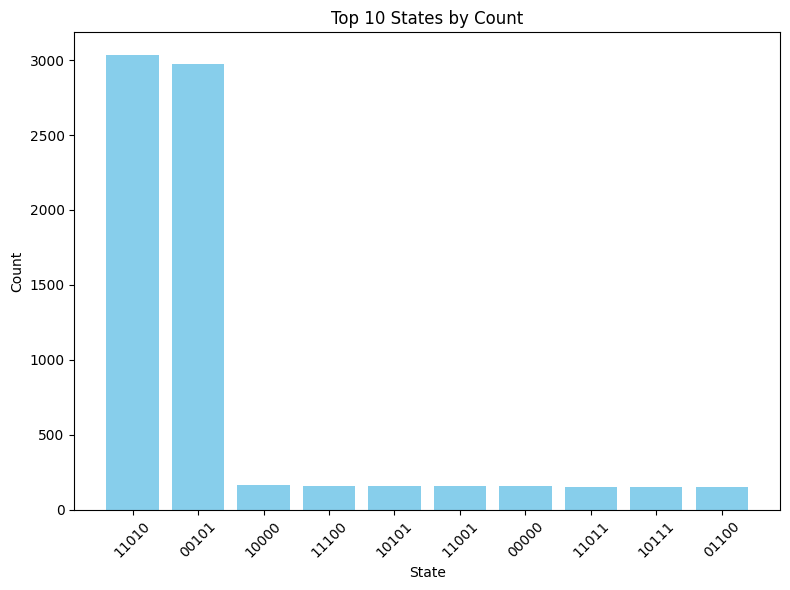

In [9]:
import matplotlib.pyplot as plt
from collections import defaultdict

# 假設 measurement_counts 已經事先定義好
# measurement_counts = [...]

# 1. 累加所有 state 的 count
state_counts = defaultdict(int)
for measurement in measurement_counts:
    for state, count in measurement.items():
        state_counts[state] += count

# 2. 依照 count 進行由大到小排序，並取前 10
top_10_states = sorted(state_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# 3. 取得要繪製的座標軸資料
states = [item[0] for item in top_10_states]
counts = [item[1] for item in top_10_states]

# 4. 繪製柱狀圖
plt.figure(figsize=(8, 6))
plt.bar(states, counts, color='skyblue')
plt.title('Top 10 States by Count')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)  # 若字串太長可調整字旋轉角度
plt.tight_layout()       # 讓圖表顯示更美觀
plt.show()


In [10]:
v.is_correct('10100')

True

In [11]:
v.is_correct('01011')

True